0:	learn: 0.6835953	test: 0.6630303	best: 0.6630303 (0)	total: 192ms	remaining: 3m 11s
200:	learn: 0.9971425	test: 0.6606061	best: 0.6806061 (57)	total: 5.86s	remaining: 23.3s
400:	learn: 1.0000000	test: 0.6651515	best: 0.6806061 (57)	total: 11.9s	remaining: 17.7s
600:	learn: 1.0000000	test: 0.6615152	best: 0.6806061 (57)	total: 17.7s	remaining: 11.7s
800:	learn: 1.0000000	test: 0.6648485	best: 0.6806061 (57)	total: 23.5s	remaining: 5.84s
999:	learn: 1.0000000	test: 0.6627273	best: 0.6806061 (57)	total: 29.2s	remaining: 0us

bestTest = 0.6806060606
bestIteration = 57

Shrink model to first 58 iterations.
Accuracy: 0.6806060606060607
              precision    recall  f1-score   support

           0       0.57      0.83      0.67      1312
           1       0.84      0.58      0.69      1988

    accuracy                           0.68      3300
   macro avg       0.70      0.71      0.68      3300
weighted avg       0.73      0.68      0.68      3300



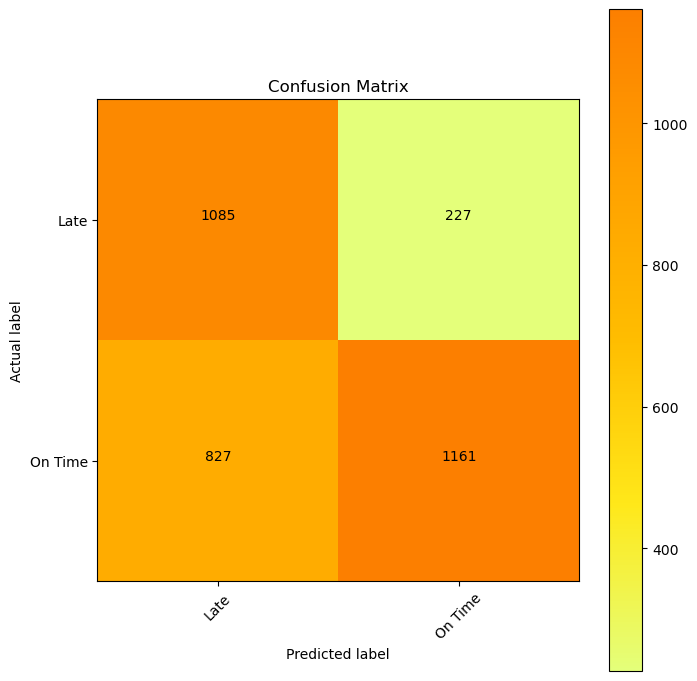

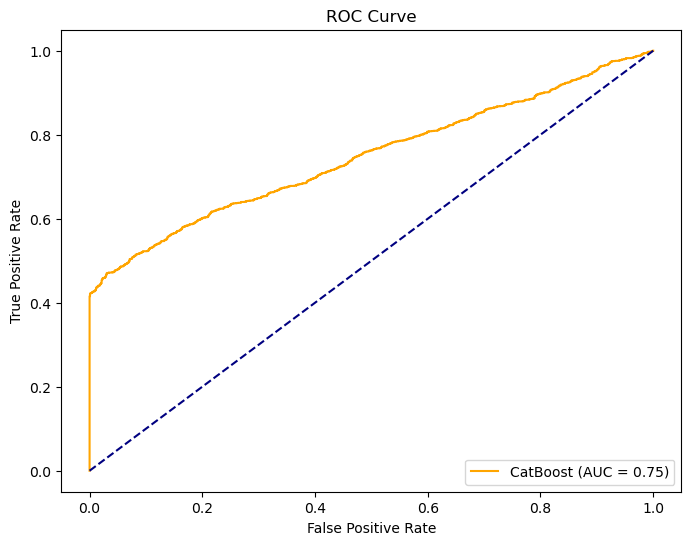

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Discount_Range,Weight_Range
0,D,Flight,4,2,177,3,low,F,44,1233,1,High,Low


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import itertools

# Load the dataset
df = pd.read_csv("C:/Users/anoop/Downloads/Train new.csv")

# Function to categorize discount into ranges
def categorize_discount(discount):
    if 0 <= discount <= 5:
        return 'Low'
    elif 5 < discount <= 20:
        return 'Medium'
    elif 20 < discount <= 100:
        return 'High'
    else:
        return 'Undefined'

# Function to categorize weight into ranges
def categorize_weight(weight):
    if 0 <= weight <= 1899:
        return 'Low'
    elif 1900 <= weight <= 4199:
        return 'Medium'
    elif 4200 <= weight <= 9000:
        return 'High'
    else:
        return 'Undefined'

df['Discount_Range'] = df['Discount_offered'].apply(categorize_discount)
df['Weight_Range'] = df['Weight_in_gms'].apply(categorize_weight)

# Dropping the 'ID' column
df = df.drop(['ID'], axis=1)

# Splitting the dataset into features and target variable
X = df.drop(['Reached.on.Time_Y.N'], axis=1)
y = df['Reached.on.Time_Y.N']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CatBoost needs to know which features are categorical (by their indices)
categorical_features_indices = np.where(X_train.dtypes != float)[0]

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=42,
    verbose=200,
    cat_features=categorical_features_indices
)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predicting
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Late', 'On Time'], rotation=45)
plt.yticks(tick_marks, ['Late', 'On Time'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="black")

plt.show()

# ROC Curve and AUC (using probabilities for the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
df.head(1)
